In [125]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import random 
import pickle as pkl 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import glob
from statsmodels.stats.multitest import multipletests
import pyensembl
from itertools import groupby
from operator import itemgetter
import statistics
import ast 
import re 
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

# real data score 

In [2]:
def max_pval_count(df): 
    max_pvalues = df.groupby("phecode")["logP"].max().reset_index()
    max_pvalues = max_pvalues.rename(columns={"logP": "max_p_value"})

    df_with_max = df.merge(max_pvalues, on='phecode')
    filtered_df = df_with_max[df_with_max["logP"] == df_with_max["max_p_value"]]

    clique_counts = filtered_df.groupby("phecode")["name"].count().reset_index()
    clique_counts = clique_counts.rename(columns={"name": "max_pvalue_clique_count"})
    df = df.merge(clique_counts, on="phecode")
    
    return df 

In [3]:
def run_score(df):
    weights = {
        "logP": 1.5,            
        "clique": 2.0,          
        "biome_penalty": 1.5,  
        "max_pval_penalty": 0.5 
    }
    
    logP_norm = (df["logP"] - df["logP"].min()) / (df["logP"].max() - df["logP"].min())
    
    clique_score = df["proportion of clique as case"]
    
    biome_penalty = 1 / (1 + df["Biome count"])  
    biome_norm = (biome_penalty - biome_penalty.min()) / (biome_penalty.max() - biome_penalty.min())
    
    max_pval_penalty = np.log1p(df["max_pvalue_clique_count"])  
    max_pval_norm = 1 - ((max_pval_penalty - max_pval_penalty.min()) / 
                         (max_pval_penalty.max() - max_pval_penalty.min())) 
    
    df["score"] = (weights["logP"] * logP_norm +
                  weights["clique"] * clique_score +
                  weights["biome_penalty"] * biome_norm +
                  weights["max_pval_penalty"] * max_pval_norm)
    
    df["score"] = (df["score"] - df["score"].min()) / (df["score"].max() - df["score"].min())
    
    return df

In [4]:
# def run_score(df, k=2): 

#     logP_norm = df["logP"] / df["logP"].max()  
    
#     biome_score = np.log(1 + df["Biome count"].max() - df["Biome count"])
#     biome_score = biome_score / biome_score.max()  # normalize to [0,1]

    
#     df["score"] = logP_norm + biome_score + df["proportion of clique as case"] 
    
#     return df

In [5]:
# biome_score = np.log(1 + df["Biome count"].max() - df["Biome count"])
# biome_score = biome_score / biome_score.max()  # normalize to [0,1]

# run score

### input data for one pop

In [154]:
icd = pd.read_csv("../all_phenotypes_binary/significant_results/aj/aj_fdr10_significant_icd.csv")
icd = icd.rename(columns={"dx_name":"phecode_string"})
icd["type"] = "ICD"

phecode = pd.read_csv("../all_phenotypes_binary/significant_results/aj/aj_fdr10_significant_phecodes.csv")
phecode["type"] = "phecode"

# phers = pd.read_csv("../all_phenotypes_binary/significant_results/aj/aj_fdr10_phers_binary_recessive_name.csv")
# phers = phers.rename(columns={"disease_name":"phecode_string"})
# phers["type"] = "phers"

merged_clusters = pd.read_csv("merged_aj_clusters.csv")
merged_clusters = merged_clusters.groupby(["group_id", "hom_samples"])["cluster_id"].unique().reset_index()
merged_clusters.columns = ["merged_cluster_id", "samples", "clusters_to_merge"]

output = "aj_test.csv"
pop="puerto rican"


In [155]:
df = pd.concat([icd, phecode])
df = max_pval_count(df)
df = run_score(df)

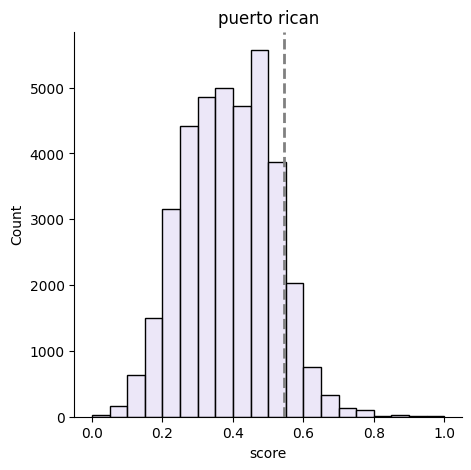

In [156]:
plt.figure(figsize=(5,5))
sns.histplot(x="score", data=df, color="#e6dff6", bins=20)
plt.axvline(x=df["score"].quantile(0.9), color="grey", linestyle="--", linewidth=2)
sns.despine()
plt.title(pop)
plt.show()

In [157]:
df.sort_values(by="score", ascending=False)[["logP", "phecode_string", "Biome count", "score"]].drop_duplicates(subset="phecode_string").head(n=20)

,logP,phecode_string,Biome count,score
28482,6.76112,Clostridium,563,1.000000
28481,6.73909,Intestinal infection due to C. difficile,545,0.997970
28480,6.73909,Clostridium difficile,545,0.997970
28476,6.67666,Disorders of phosphorus metabolism,320,0.996336
28512,6.43110,Overactive bladder,905,0.963894
28466,6.43122,Gastrointestinal inflammation,7654,0.960320
28513,6.30747,Squamous cell carcinoma of the skin,431,0.955754
28636,6.86254,Cryptogenic organizing pneumonia,19,0.935343
28511,6.00255,Bacterial enteritis,2201,0.917816
28510,5.97849,Cartilage tear of knee,1120,0.916977


In [158]:
# df.to_csv("dr_test.csv")

# collapse 

### metadata

In [159]:
phecodes = pd.read_csv("../../pheno/phecodes/phecodeX_unrolled_ICD_CM.csv")
icd_per_phecode = phecodes.groupby("phecode")["ICD"].unique().apply(list).reset_index()

icd_key = pkl.load(open("../../pheno/icd_categories.pkl", "rb"))

In [160]:
all_case_counts = pd.read_csv("../../pheno/phecode_icd_counts.csv")

largest_count = 3000 

### filter

In [161]:
df = df[df["Biome count"] < largest_count]

In [162]:
df["phecode_rounded"] = df["phecode"].str[:5]

mask = df["category"].isna()
df.loc[mask, "category"] = df.loc[mask, "phecode_rounded"].map(icd_key)


In [163]:
filter_items = ["Mental", "Health status", "Infections"]

df = df[~df["category"].isin(filter_items)]
df = df[~df["phecode_string"].isin(filter_items)]

In [164]:
patterns = ["allerg", "abuse", "exposure", "vaccin", "scratch", "choking", "burn",
                     "bite", "collision", "fracture", "overdose", "rash", "striking", 
                     "traumatic", "foreign", "assault", "infection", "travel", "aquired", 
                    "incarcerated"]

df = df[~df["phecode_string"].str.lower().str.contains("|".join(
    patterns), case=False, na=False)]

In [165]:
df = df.rename(columns={"0":"chr", "2":"start", "3":"end"})

# collapse

In [166]:
def process_numeric_values(values_dict, include_median=False):
    """Calculate statistics for numeric values"""
    result = {}
    for col, values in values_dict.items():
        result[f"max_{col}"] = max(values)
        result[f"avg_{col}"] = sum(values) / len(values)
        if include_median:
            result[f"median_{col}"] = statistics.median(values)
    return result

In [167]:
def process_region(chrom, start, end, conditions, phecodes, numeric_values, condition_for_score, 
                   filtered_conditions=None, highest_score_coords=None, unique_categories=None):
    """Create a result row for a merged region"""
    result_row = {
        "chrom": chrom,
        "start": start,
        "end": end,
        "conditions": conditions,
        "phecode": phecodes,
        "number of phecodes": len(phecodes)
    }
    
    # Add filtered conditions if provided
    if filtered_conditions is not None:
        result_row["conditions_min_2_cases"] = filtered_conditions
    
    # Add highest score coordinates if available
    if highest_score_coords is not None:
        result_row["highest_score_coords"] = highest_score_coords
    
    # Add unique categories if provided
    if unique_categories is not None:
        result_row["unique_categories"] = unique_categories
    
    # Add statistics for numeric columns
    result_row.update(process_numeric_values(numeric_values))
    
    # Add condition with max score if available
    if "score" in numeric_values:
        max_score = max(numeric_values["score"])
        result_row["condition_with_max_score"] = condition_for_score[max_score]
    
    return result_row

In [168]:
def merge_clusters_by_key(df, merge_key_df, numeric_cols=None, min_case_count=2, category_col="category"):
    """
    Merges clusters based on a provided merge key dataframe rather than by position overlap.
    Tracks counts of each category in merged clusters.
    """    
    if numeric_cols is None:
        numeric_cols = ["logP", "proportion of clique as case", "score", "Biome count"]
    
    # Create a mapping from original cluster ID to merged cluster ID
    cluster_to_merged = {}
    for _, row in merge_key_df.iterrows():
        for cluster_id in row["clusters_to_merge"]:
            cluster_to_merged[cluster_id] = row["merged_cluster_id"]
    
    # Add the merged cluster ID to the original dataframe
    df_with_merged = df.copy()
    
    df_with_merged["merged_cluster_id"] = df_with_merged["name"].map(
        lambda x: cluster_to_merged.get(x, x)  # Use original ID if not in mapping
    )
    
    results = []
    
    # Group by merged cluster ID
    for merged_id, group in df_with_merged.groupby("merged_cluster_id"):
        if len(group) == 0:
            continue
        
        # Determine chromosome - should be same for all rows in a merged cluster
        chrom = group["chr"].iloc[0]
        
        # Find min start and max end positions
        current_start = group["start"].min()
        current_end = group["end"].max()
        
        # Collect all conditions
        current_conditions = []
        current_phecode = []
        current_case_counts = {}
        current_condition_strings = {}
        
        # Track categories with counts using Counter
        category_counter = Counter()
        
        for _, row in group.iterrows():
            prevalence = row["Biome count"]
            clique_count = row["clique_case_count"]
            phecode = row["phecode"]
            condition_name = row["phecode_string"]
            condition_display = f"{condition_name} ({clique_count}, {prevalence})"
            
            if condition_display not in current_conditions:
                current_conditions.append(condition_display)
                current_phecode.append(phecode)
            
            current_case_counts[condition_name] = clique_count
            current_condition_strings[condition_name] = condition_display
            
            # Count category occurrences if the column exists
            if category_col in row:
                category_counter[str(row[category_col])] += 1
        
        # Track numeric values
        current_values = {col: list(group[col]) for col in numeric_cols if col in df.columns}
        
        # Track condition for score
        condition_for_score = {}
        score_to_coords = {}
        if "score" in df.columns:
            for _, row in group.iterrows():
                condition_for_score[row["score"]] = f"{row['phecode_string']} ({row['clique_case_count']}, {row['Biome count']})"
                score_to_coords[row["score"]] = f"{chrom}:{row['start']}-{row['end']}"
        
        # Create filtered condition list based on case count
        filtered_conditions = [
            current_condition_strings[cond] 
            for cond in current_case_counts
            if current_case_counts[cond] >= min_case_count
        ]
        
        # Get coordinates of the highest scoring row
        highest_score_coords = None
        if "score" in df.columns and score_to_coords:
            max_score = max(current_values.get("score", [])) if current_values.get("score") else None
            if max_score is not None:
                highest_score_coords = score_to_coords.get(max_score)
        
        # Format categories with counts: "category1 (count1), category2 (count2), ..."
        categories_with_counts = None
        if category_counter:
            categories_with_counts = ", ".join([f"{cat} ({count})" for cat, count in sorted(category_counter.items())])
        
        # Process the merged region - modify the process_region function call to include categories_with_counts
        result_row = process_region(
            chrom, current_start, current_end, 
            current_conditions, current_phecode,
            current_values, condition_for_score,
            filtered_conditions, highest_score_coords, categories_with_counts
        )
        
        # Add the merged cluster ID to the result
        result_row["merged_cluster_id"] = merged_id
        
        results.append(result_row)
    
    # Create the result DataFrame
    result_df = pd.DataFrame(results)
    return result_df

In [169]:
collapsed_df = merge_clusters_by_key(df, merged_clusters)

In [170]:
# collapsed_df

In [171]:
# collapsed_df.to_csv("pr_test.csv")

In [172]:
# collapsed_df.to_csv("pr_test.csv")

# annotate

In [173]:
omim = pd.read_csv("../../omim/genemap2.txt", sep="\t").dropna(subset="Phenotypes")

In [174]:
clinvar = pd.read_csv("../../clinvar/variant_summary_pathogenic.csv")

In [175]:
clinvar = clinvar[["Type", "GeneSymbol", "ClinicalSignificance", "PhenotypeList",
                   "OriginSimple", "ReviewStatus", "NumberSubmitters"]]

In [176]:
clinvar = clinvar[clinvar["ClinicalSignificance"].isin(["Pathogenic", "Likely pathogenic", 
                                              "Pathogenic/Likely pathogenic", "Pathogenic; other", 
                                             "Pathogenic; drug response", 
                                             "Pathogenic; risk factor"])]

In [177]:
clinvar["Condition(s)"] = clinvar["PhenotypeList"].str.split("|").str[0]


In [178]:
clinvar = clinvar[~clinvar["Condition(s)"].isin(["not provided", "not specified"])]

clinvar["Gene(s)"] = clinvar["GeneSymbol"].str.split("|").str[0]
clinvar["Gene(s)"] = clinvar["Gene(s)"].str.split("-").str[0]

clinvar = clinvar[["Gene(s)", "Condition(s)", "ReviewStatus"]].dropna().drop_duplicates()

In [179]:
clinvar_grouped = clinvar.groupby(["Gene(s)", "ReviewStatus"])["Condition(s)"].unique().reset_index()
clinvar_grouped["combined"] = clinvar_grouped["Gene(s)"] + ": " + clinvar_grouped["Condition(s)"].astype(str).str.replace("\n", " ").str.replace("\r", " ").str.replace("\t", " ").str.replace("  +", " ", regex=True).str.strip()

omim_grouped = omim.groupby("Gene/Locus And Other Related Symbols")["Phenotypes"].unique().reset_index()
omim_grouped["combined"] = omim_grouped["Gene/Locus And Other Related Symbols"] + ": " + omim_grouped["Phenotypes"].astype(str)

In [180]:
data = pyensembl.EnsemblRelease(release=104)

# Process genes and create new columns in one pass
results = []

for _, row in collapsed_df.iterrows():
    chrom = row["chrom"]
    min_pos = row["start"]
    max_pos = row["end"]
    
    highest_chrom = row["highest_score_coords"].split(":")[0]
    highest_start = row["highest_score_coords"].split(":")[1].split("-")[0]
    highest_end = row["highest_score_coords"].split(":")[1].split("-")[1]
    
    # Get gene list for locus
    genes = data.genes_at_locus(int(chrom), min_pos, max_pos)
    gene_list = sorted(list(set([g.gene_name for g in genes if len(g.gene_name) > 1])))
    
    top_region_genes = data.genes_at_locus(int(highest_chrom), int(highest_start), int(highest_end))
    top_region_gene_list = sorted(list(set([g.gene_name for g in top_region_genes if len(g.gene_name) > 1])))
        
    # Process OMIM data
    matched_omim_genes = np.array(omim[omim["Gene/Locus And Other Related Symbols"].isin(gene_list)]["Gene/Locus And Other Related Symbols"]).tolist()
    matched_omim_conditions = np.array(omim_grouped[omim_grouped["Gene/Locus And Other Related Symbols"].isin(gene_list)]["combined"]).tolist()
    
    # Process ClinVar data - base matching
    clinvar_matches = clinvar[clinvar["Gene(s)"].isin(gene_list)]
    matched_clinvar_genes = set(np.array(clinvar_matches["Gene(s)"]).tolist())
    
    # Get all ClinVar conditions
    clinvar_grouped_matches = clinvar_grouped[clinvar_grouped["Gene(s)"].isin(gene_list)]
    matched_clinvar_conditions = np.array(clinvar_grouped_matches["combined"]).tolist()
    
    # Create separate condition lists by evidence type
    evidence_types = clinvar_grouped["ReviewStatus"].unique()
    
    # Initialize dictionaries for each evidence type
    clinvar_by_evidence = {}
    for evidence_type in evidence_types:
        evidence_matches = clinvar_grouped_matches[clinvar_grouped_matches["ReviewStatus"] == evidence_type]
        clinvar_by_evidence[evidence_type] = np.array(evidence_matches["combined"]).tolist() if not evidence_matches.empty else []
    
    # Collect all results for this row
    result_dict = {
        "genes": gene_list,
        "top region genes": top_region_gene_list,
        "omim genes": matched_omim_genes,
        "omim conditions": matched_omim_conditions,
        "number of omim genes": len(matched_omim_genes),
        "clinvar genes": matched_clinvar_genes,
        "clinvar conditions": matched_clinvar_conditions,
        "number of clinvar genes": len(matched_clinvar_genes)
    }
    
    # Add evidence-specific conditions
    for evidence_type in evidence_types:
        column_name = f"clinvar conditions ({evidence_type})"
        result_dict[column_name] = clinvar_by_evidence[evidence_type]
    
    results.append(result_dict)

# Update dataframe with all new columns at once
for key in results[0].keys():
    collapsed_df[key] = [result[key] for result in results]

In [181]:
# collapsed_df.sort_values(by="max_score", ascending=False).to_csv("pr_test.csv")

In [182]:
# collapsed_df.head()

In [183]:
# collapsed_df.to_csv("aj_test_gene.csv")

# age at diagnosis 

In [184]:
def add_ind_stats(collapsed_df, column, phecode_strings, pheno_age):
    result = []
    
    phecode_mapping = {}
    for _, row in phecode_strings.iterrows():
        phecode_mapping[row["phecode_string"]] = row["phecode"]
    
    for i, row in collapsed_df.iterrows():
        individuals = row["merged_cluster_id"].split("_")
        
        pheno_age_ind = pheno_age[pheno_age["masked_mrn"].isin(individuals)]
        
        updated_items = []
        for item in row[column]:
            string_name = item.split("(")[0].strip()
            if "[" in string_name:
                string_name = string_name.split("[")[0].strip()
            
            matching_phecodes = [code for name, code in phecode_mapping.items() if string_name in name]
            if matching_phecodes:
                code = matching_phecodes[0]
                
                ages = pheno_age_ind[pheno_age_ind["phecode"] == code]["age_at_diagnosis"].values
                frq = pheno_age_ind[pheno_age_ind["phecode"] == code]["frq"].values

                condition_with_stats = f"{item.split(')')[0]}, {ages}, {frq} )"
                updated_items.append(condition_with_stats)
            else:
                updated_items.append(item)
        
        result.append(updated_items)
    
    return result

# phenotype info

In [185]:
phecode_strings = df[["phecode", "phecode_string"]].drop_duplicates()

In [186]:
phecode_age = pd.read_csv("../../pheno/age_at_first_diagnosis_phecode.csv")

icd_age = pd.read_csv("../../pheno/age_at_first_diagnosis_icd.csv")
icd_age = icd_age.rename(columns={"dx_code1":"phecode"})

pheno_age = pd.concat([phecode_age, icd_age])
pheno_age["masked_mrn"] = pheno_age["masked_mrn"].astype(int).astype(str)

In [187]:
phecode_frq = pd.read_csv("../../pheno/phecode_freq.csv")

icd_frq = pd.read_csv("../../pheno/icd_freq.csv")
icd_frq = icd_frq.rename(columns={"dx_code1":"phecode"})

phecode_frq = pd.concat([phecode_frq, icd_frq])
phecode_frq["masked_mrn"] = phecode_frq["masked_mrn"].astype(int).astype(str)
phecode_frq = phecode_frq.rename(columns={"contact_date":"frq"})

In [188]:
pheno_age = pheno_age.merge(phecode_frq, on=["phecode", "masked_mrn"])

# add to dataframe

In [189]:
collapsed_df["conditions_min_2_age_of_onset"] = add_ind_stats(collapsed_df, "conditions_min_2_cases", phecode_strings, pheno_age)

In [190]:
collapsed_df["conditions_age_of_onset"] = add_ind_stats(collapsed_df, "conditions", phecode_strings, pheno_age)

In [191]:
collapsed_df.to_csv("aj_test.csv", index=False) 